In [110]:

%time
import followthemoney as ftm
import followthemoney.model as model
import pandas
import json
import numpy as np
import math
from urllib import parse as url_parse
from pprint import pprint
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as metrics 
from sklearn.preprocessing import OneHotEncoder

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


# Importing and preprocessing

In [2]:
# local import for easier reproducibility 
json_path = "./data/meineabgeordneten_3.json"

entity_dicts = []
with open(json_path) as f:
    for line in f:
        entity_dicts.append(json.loads(line))

In [309]:
person_dicts = [entity for entity in entity_dicts if entity["schema"] == "Person"]
ftm_proxies =[model.get_proxy(entity) for entity in entity_dicts]
ftm_persons = [proxy for proxy in ftm_proxies if proxy.schema.name == "Person"]
ftm_organizations = [proxy for proxy in ftm_proxies if proxy.schema.name == "Organization"]
ftm_companies = [proxy for proxy in ftm_proxies if proxy.schema.name == "Company"]
person_assignments = pandas.read_csv("./data/csv/new/Person_wikidata.csv")[["id", "wikidata"]]
#person_assignments.where(pandas.notnull(person_assignments, None))
#person_assignments.loc[person_assignments["wikidata"] == pandas.NA] = None
#person_assignments = person_assignments["wikidata"].to_frame().loc[person_assignments["wikidata"] == "na", pandas.NA]

In [310]:
person_assignments

,id,wikidata
0,00023638949ec143e690ae151d28e389574f07dc,Q51533040
1,001d48bf2913572202d88f00e35262f490771b40,Q81526090
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,Q20752545
3,00def69ad3d13efe8151da80f1485a692954d183,Q102353097
4,00e70efc17aff680e675349ca87d7b80be04c452,Q50843964
...,...,...
761,fcc94a122228733902b6f601abc54631aa205a4b,Q54956531
762,fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,Q84091498
763,fdc8f2275cf8bea8331ea4a779755915d0c29363,NaN
764,fe532c498a07fc06380579af855e68389239c43b,Q19501935


In [56]:
len(ftm_persons)

766

All properties of entities are multivalued, although they mostly hold only one single value. I transform the data in order to call the API with single-valued properties.

In [311]:
flat_entities = []
for entity in ftm_persons:
    prop_dict ={}
    for prop, val in entity.properties.items():
        prop_dict["id"] = entity.id
        prop_dict[prop] = val[0] if len(val)== 1 else  val
    flat_entities.append(prop_dict)


In [312]:
# Dataframe with Wikidata Cells
clean_person_df = pandas.DataFrame.from_dict(flat_entities).merge(person_assignments,on="id")
clean_person_df

,id,birthDate,birthPlace,country,email,firstName,lastName,name,sourceUrl,summary,website,title,wikidata
0,00023638949ec143e690ae151d28e389574f07dc,1987-02-23,Innsbruck,at,buero.wohlgemuth@oegb.at,Philip,Wohlgemuth,Philip Wohlgemuth,https://www.meineabgeordneten.at/Abgeordnete/p...,Abgeordneter zum Landtag,"[https://www.instagram.com/philip_wohlgemuth/,...",NaN,Q51533040
1,001d48bf2913572202d88f00e35262f490771b40,1976-06-25,Wiener Neustadt,at,waltraud.ungersboeck@noel.gv.at,Waltraud,Ungersböck,Waltraud Ungersböck,https://www.meineabgeordneten.at/Abgeordnete/W...,"[Vizebürgermeisterin, Abgeordnete zum Landtag,...",[https://www.facebook.com/profile.php?id=10001...,NaN,Q81526090
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,1971-02-27,Rottenmann,at,armin.forstner@stvp.at,Armin,Forstner,Armin Forstner,https://www.meineabgeordneten.at/Abgeordnete/a...,"[Regionalmanagement Bezirk Liezen, Abgeordnete...",https://www.facebook.com/a.forstner/,NaN,Q20752545
3,00def69ad3d13efe8151da80f1485a692954d183,1980-10-20,Wien,at,spassfabrik@gmx.at,Silvia,Janoch,Silvia Janoch,https://www.meineabgeordneten.at/Abgeordnete/s...,[Schriftführerin des Wiener Landtages und Geme...,https://www.facebook.com/silvia.janoch,Dipl.-Päd.,Q102353097
4,00e70efc17aff680e675349ca87d7b80be04c452,1970-07-10,Eisenstadt,at,elvira.schmidt@spoe.at,Elvira,Schmidt,Elvira Schmidt,https://www.meineabgeordneten.at/Abgeordnete/e...,"[Mitglied des Gemeinderates, Ich schaff das - ...",https://www.facebook.com/virli.schmidt,NaN,Q50843964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,fcc94a122228733902b6f601abc54631aa205a4b,1963-01-16,Radstadt,at,liesl.weitgasser@neos.eu,Elisabeth,Weitgasser,Elisabeth Weitgasser,https://www.meineabgeordneten.at/Abgeordnete/e...,"[S-berg Hotel Ges.m.b.H., Abgeordnete zum Land...","[https://www.instagram.com/weitgasserliesl/, h...",NaN,Q54956531
762,fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,1966-11-04,Wien,at,elisabeth.trummer.spoe@gmail.com,Elisabeth,Trummer,Elisabeth Trummer,https://www.meineabgeordneten.at/Abgeordnete/e...,"[""Sozial- und Gesundheitsplattform Oberpullend...",https://www.facebook.com/Trummerelisabeth,NaN,Q84091498
763,fdc8f2275cf8bea8331ea4a779755915d0c29363,NaN,NaN,at,daniela.schmid@ages.at,Daniela,Schmid,Daniela Schmid,https://www.meineabgeordneten.at/Abgeordnete/d...,NaN,NaN,Priv.-Doz.in Dr.in,NaN
764,fe532c498a07fc06380579af855e68389239c43b,1964-06-30,Graz,at,andrea-michaela.schartel@parlament.gv.at,Andrea Michaela,Schartel,Andrea Michaela Schartel,https://www.meineabgeordneten.at/Abgeordnete/A...,"[Österreichischer Kameradschaftsbund, Ortsverb...",[https://www.facebook.com/Andrea-Michaela-Scha...,NaN,Q19501935


# Reconciliation

In [10]:
import requests
import urllib
reconciliation_endpoint = urllib.parse.urlparse("https://wikidata.reconci.link/de/api")

In [10]:
reconciliation_endpoint

ParseResult(scheme='https', netloc='wikidata.reconci.link', path='/en/api', params='', query='', fragment='')

Ontology alignment for subset of Person properties.

In [144]:
mapping = {
    "birthDate" : "P569",
    "birthPlace" : "P19",
    "email" : "P968",
    "firstName" : "P735",
    "lastName" : "P734",
    "title" : "P512",
    "website" : "P856"
}
query = "name"

In [ ]:
# email field emitting leads to higher scores, but matchign decision same

In [142]:
def createQuery(entity, type, limit = 10):
    if entity.schema.name != "Person":
        return null
    query_params = {}
    query_params["query"] = entity.first("name")
    query_params["type"] = type
    query_params["properties"] = []
    query_params["limit"] = limit # candidate limit
    for prop, value in entity.properties.items():
        #print(prop, mapping.get(prop))
        wikidataId = mapping.get(prop)
        if wikidataId:
            prop = {"pid": wikidataId, "v": value[0] if len(value)== 1 else  value}
            query_params["properties"].append(prop)   
 
    return query_params
    


In [34]:
createQuery(ftm_persons[3], "Q5")

{'query': 'Philip Wohlgemuth',
 'type': 'Q5',
 'properties': [{'pid': 'P569', 'v': '1987-02-23'},
  {'pid': 'P19', 'v': 'Innsbruck'},
  {'pid': 'P968', 'v': 'buero.wohlgemuth@oegb.at'},
  {'pid': 'P735', 'v': 'Philip'},
  {'pid': 'P734', 'v': 'Wohlgemuth'},
  {'pid': 'P856',
   'v': ['https://www.facebook.com/philip.wohlgemuth',
    'https://twitter.com/phwohlgemuth',
    'https://www.instagram.com/philip_wohlgemuth/']}],
 'limit': 10}

In [17]:
def create_batch_queries(entities, type, batch_size = 10):
    start = 0
    end = 0 + batch_size
    batches =[]
    for batch_nr in range(math.ceil(len(entities)/batch_size)):
        queries = {"q"+str(i):createQuery(entity, "Q5") for i, entity in enumerate(ftm_persons[start:end])}
        batches.append(queries)
        start += batch_size
        end += batch_size
    return batches
    

In [18]:
def query_endpoint(query_batches):
    results = []
    for batch_query in query_batches:
        # Endpoint only accepts double quotes, not single quotes.
        urlencoded = url_parse.quote_plus(json.dumps(batch_query))
        response = requests.get(reconciliation_endpoint.geturl()+ "?queries=" + urlencoded)
        results.extend([resp for index, resp in response.json().items()])
    return results

In [23]:
batch_query = create_batch_queries(ftm_persons, "Q5") # Q5 is the Wikidata ID for type "Human".
results = query_endpoint(batch_query)



In [313]:
#json.dump(results, open("./data/intermediate/api_responses.json","w"))
results = json.load(open("./data/intermediate/api_responses.json"))

766

# Analysis

In [17]:
print(entity)

id
birthDate
birthPlace
country
email
firstName
lastName
name
sourceUrl
summary
website
title
wikidata


Knitting together API response and data to create a pandas table for further processing. 

In [410]:

intermed_table = []
header = ["id", "name", "cd_wd_id", "cd_name","cd_match_estimate", "cd_score"]
for result, entity in zip(results, ftm_persons):
    candidates = result["result"]
    if len(candidates) > 0: 
        for candidate in candidates:
            intermed_table.append([entity.id,entity.first("name"), candidate["id"], candidate["name"], \
                candidate["match"], candidate["score"]])
    # If no results in response
    else: 
        intermed_table.append([entity.id,entity.first("name"), None, 
            None, False, None]) # implicit false made explicit

cd_table = pandas.DataFrame(intermed_table, columns= header).merge(person_assignments,on="id")
cd_table["match"] = cd_table["wikidata"] == cd_table["cd_wd_id"]

#cd_table["wikidata"] = cd_table["wikidata"].astype(str)
#cd_table["cd_wd_id"] = cd_table["cd_wd_id"].astype(str)
cd_table


,id,name,cd_wd_id,cd_name,cd_match_estimate,cd_score,wikidata,match
0,00023638949ec143e690ae151d28e389574f07dc,Philip Wohlgemuth,Q51533040,Philip Wohlgemuth,True,76.470588,Q51533040,True
1,001d48bf2913572202d88f00e35262f490771b40,Waltraud Ungersböck,Q81526090,Waltraud Ungersböck,True,76.470588,Q81526090,True
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,Armin Forstner,Q20752545,Armin Forstner,False,64.705882,Q20752545,True
3,00def69ad3d13efe8151da80f1485a692954d183,Silvia Janoch,Q102353097,Silvia Janoch,False,47.368421,Q102353097,True
4,00e70efc17aff680e675349ca87d7b80be04c452,Elvira Schmidt,Q50843964,Elvira Schmidt,True,76.470588,Q50843964,True
...,...,...,...,...,...,...,...,...
1446,fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q89189322,Daniela Schmidt,False,66.846154,NaN,False
1447,fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q97706069,Daniela Schmidt,False,66.846154,NaN,False
1448,fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q97706899,Daniela-Felicitas Schmid,False,28.461538,NaN,False
1449,fe532c498a07fc06380579af855e68389239c43b,Andrea Michaela Schartel,Q19501935,Andrea-Michaela Schartel,True,76.470588,Q19501935,True


Before calculating scores based on similarity measures, the Wikidata Reconciliation API performs a candidate selection based on the WikiMedia API Elasticsearch search-engine by querying the value in the "query" property inside the request, which is the name of an item. Obviously, there is a high tendency to return just one (matching result)

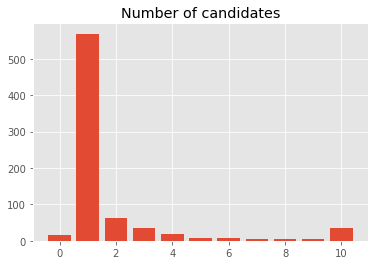

In [411]:
cd_num_counts = pandas.DataFrame([len(result["result"]) for result in results], columns=["cd_num"])
cd_occ_counts =  cd_num_counts.groupby("cd_num").size().to_frame("count")

plt.bar(cd_occ_counts.index, cd_occ_counts["count"])
plt.title("Number of candidates")
plt.style.use("ggplot")

In [412]:
#cd_table["is_match"] = cd_table["match"] and (cd_table["cd_wd_id"] == cd_table["wikidata"]] 
cd_first_candidate = cd_table.groupby("id").first()
cd_first_candidate

,name,cd_wd_id,cd_name,cd_match_estimate,cd_score,wikidata,match
id,,,,,,,
00023638949ec143e690ae151d28e389574f07dc,Philip Wohlgemuth,Q51533040,Philip Wohlgemuth,True,76.470588,Q51533040,True
001d48bf2913572202d88f00e35262f490771b40,Waltraud Ungersböck,Q81526090,Waltraud Ungersböck,True,76.470588,Q81526090,True
00ad3c5b5a651f6e00080803ffefb1d306c6d027,Armin Forstner,Q20752545,Armin Forstner,False,64.705882,Q20752545,True
00def69ad3d13efe8151da80f1485a692954d183,Silvia Janoch,Q102353097,Silvia Janoch,False,47.368421,Q102353097,True
00e70efc17aff680e675349ca87d7b80be04c452,Elvira Schmidt,Q50843964,Elvira Schmidt,True,76.470588,Q50843964,True
...,...,...,...,...,...,...,...
fcc94a122228733902b6f601abc54631aa205a4b,Elisabeth Weitgasser,Q54956531,Elisabeth Weitgasser,False,64.705882,Q54956531,True
fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,Elisabeth Trummer,Q84091498,Elisabeth Trummer,True,76.470588,Q84091498,True
fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q87653139,Daniela Schmid,False,69.230769,NaN,False


Text(0.5, 1.0, 'Well known entities - Number of items existing on Wikidata')

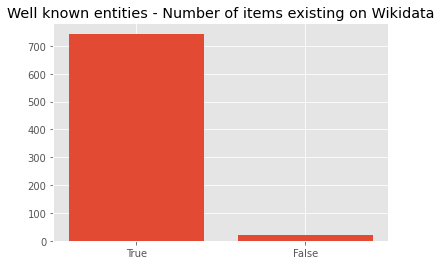

In [414]:
has_match = ~cd_first_candidate["wikidata"].isna()
has_match.value_counts()
plt.bar(["True", "False"],has_match.value_counts())
plt.title("Well known entities - Number of items existing on Wikidata")



## Overview 
The threshold of Wikidata's Reconciliation Service was automatically set by the service, following this equation:

$t = t_{val} - d \cdot |p| = 95 - 5 \cdot |p|$

where:<br>
$t_{val}$ ... the fixed validation threshold set by the service. This value is statically set to 95<br>
$d$ ... The fixed validation discount set by the service. This value is statically set to 5 <br>
$p$ ... The set of properties queried

In most cases the property size was 6, leading to a threshold of 65. 

Candidates that exceeded this threshold are considered as a match. Other candidates returned are potential matches for further human judgment. However, there is no minimum threshold, but a maximum of candidates set. In this case, not more than 10 Candidates are retrieved.

In [415]:

#cd_table["match_in_cd"] = cd_table.groupby("id").any("match")
cd_table["estimate"] = np.select([
    cd_table["cd_match_estimate"] & cd_table["match"],
    cd_table["cd_wd_id"].isna(),
], [
    "match",
    "no_match"
],default="par_match")

any(cd_table["estimate"].isna()) # sanity check
cd_first_candidate = cd_table.groupby("id").first()


In [ ]:
In most cases, there was no match decision taken by the service

par_match    986
match        449
no_match      16
Name: estimate, dtype: int64

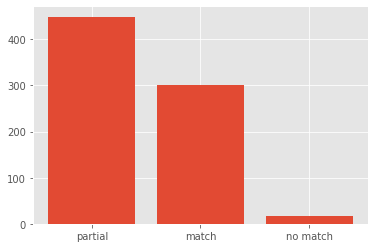

In [417]:
cd_first_candidate["estimate"].value_counts()
plt.bar(["partial", "match", "no match"],cd_first_candidate["estimate"].value_counts())
cd_table["estimate"].value_counts()

In [206]:
truth = cd_first_candidate["wikidata"].values
estimate 
{"precision:" : metrics.precision_score(cd_first_candidate["wikidata"].values,cd_first_candidate["cd_wd_id"].values, average="macro")}

{'precision:': 0.9673629242819843}

In [204]:
#metrics.top_k_accuracy_score(cd_first_candidate["wikidata"].values,cd_first_candidate["cd_wd_id"].values )

metrics.accuracy_score(cd_first_candidate["wikidata"].values,cd_first_candidate["cd_wd_id"].values)

0.9673629242819843

In [113]:
onehot = OneHotEncoder(sparse=False)

In [128]:
cd_first_candidate["cd_wd_id"]

id
00023638949ec143e690ae151d28e389574f07dc     Q51533040
001d48bf2913572202d88f00e35262f490771b40     Q81526090
00ad3c5b5a651f6e00080803ffefb1d306c6d027     Q20752545
00def69ad3d13efe8151da80f1485a692954d183    Q102353097
00e70efc17aff680e675349ca87d7b80be04c452     Q50843964
                                               ...    
fcc94a122228733902b6f601abc54631aa205a4b     Q54956531
fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e     Q84091498
fdc8f2275cf8bea8331ea4a779755915d0c29363     Q87653139
fe532c498a07fc06380579af855e68389239c43b     Q19501935
fea62afd157dd3f7ec3253d21547bb3b0a6f30bf     Q81616188
Name: cd_wd_id, Length: 766, dtype: object